<br>
<br>
<center>
    
# 人工智能高阶人才培训班

<br>

> ## 如何构建一个人工智能项目(一)
</center>
<img src='../static/img/logo.jpg' align='right' style="width:260px;height:60px;display:block"/>
<br>


# 猫🐱-狗🐕分类问题


![](img/cat-dog.jpeg)

> 背景：Kaggle比赛，25，000张训练图像,通过使用深度学习算法，kaggle上目前取得了98%的准确率，我们仅使用8%的数据集，一起来看下效果

在本次实验中，我们一起探讨如何通过迁移学习方法利用预训练模型实现猫狗分类问题，只利用很少的一部分数据集取得不错的效果。

在本次实验中，我们将遵循人工智能项目的构建流程，按照如下步骤完成实验：
0. 定义问题
1. 了解数据
2. 构建数据工作的pipeline

3. 构建模型
    * 使用预训练模型
    * 添加分类器

4. 训练模型
5. 评估模型

In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  2.4.1


## 0. 问题定义

> 猫狗分类实质上是一个二分类问题，输入的是图像数据，输出的是分类的结果

## 1. 数据导入及数据理解

### 下载并获取数据 - cats_and_dogs_filtered.zip
Kaggle 中原始数据可以通过链接 [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) 获取。本实验只使用其一个子集。

In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

68608000/68606236 [==============================] - 8s 0us/step


In [3]:
base_dir

'/home/jovyan/.keras/datasets/cats_and_dogs_filtered'

### 准备训练数据和验证数据


In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


> 训练样本很平衡

### 创建数据生成器

In [5]:
image_size = 160 # All images will be resized to 160x160
batch_size = 128

In [6]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 随机查看一组数据

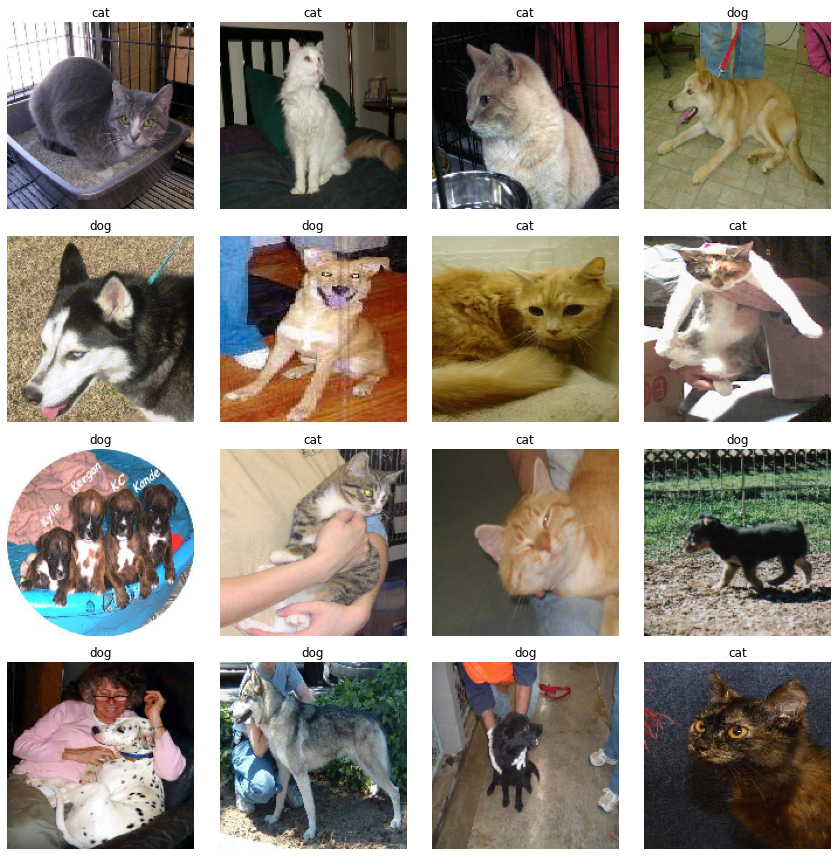

In [7]:
plt.figure(figsize=(12,12))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.axis('off')
        plt.imshow(image)
        label = "dog" if Y_batch[0]==1 else "cat" 
        plt.title(label)
        break
plt.tight_layout()
plt.show()

## 使用预训练模型构建解决该问题的基准模型

在本节中，我们使用 在ImageNet数据集中预训练的**MobileNet V2** 模型来构建基准模型。

我们首先使用MobileNet-v2的主干网络进行特征提取，最常用的方法是使用Flatten操作之后一层的输出作为特征提取的输出层。因为在卷积神经网络之中，越靠后面的层学习特征的针对性越强，不利于泛化迁移。


In [8]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


## 特征提取

我们将冻住卷积层的权重，将其作为特征提取器来用，在最后通过增加分类器，训练属于我们自己的新的网络。

### 冻结卷积层

通过利用 `layer.trainable = False` 冻结卷积层，我们可以阻止该部分权重的更新操作。

In [9]:
base_model.trainable = False

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

#### 增加分类器

在上述模型的基础上，添加我们需要的分类器

In [11]:
model = tf.keras.Sequential([
      base_model,
      keras.layers.GlobalAveragePooling2D(),
      keras.layers.Dense(1, activation='sigmoid')
])

> 关于GlobalAveragePooling

![](img/global_pooling.jpeg)

### 编译模型
在模型训练之前，通过编译，告诉模型优化目标和优化方法

> 特别注意学习率

In [12]:
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


These 1.2K trainable parameters are divided among 2 TensorFlow `Variable` objects, the weights and biases of the two dense layers:

In [14]:
len(model.trainable_variables)

2

In [15]:
model.trainable_variables[0]

<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.01605061],
       [-0.06619418],
       [ 0.06443322],
       ...,
       [-0.06514558],
       [-0.023787  ],
       [ 0.01534863]], dtype=float32)>

In [16]:
model.trainable_variables[1]

<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

### 模型训练

训练10个迭代，我们就已经取得了~94%的准确率；

如果你可以使用更多的训练迭代，预计可以收敛更好的准确率(比如尝试使用50轮迭代， ~96%)

In [17]:
#epochs = 10
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
15/15 [==============================] - 57s 4s/step - loss: 0.4762 - accuracy: 0.7821 - val_loss: 0.1929 - val_accuracy: 0.9475
Epoch 2/10
15/15 [==============================] - 53s 3s/step - loss: 0.1755 - accuracy: 0.9525 - val_loss: 0.1394 - val_accuracy: 0.9565
Epoch 3/10
15/15 [==============================] - 52s 3s/step - loss: 0.1216 - accuracy: 0.9628 - val_loss: 0.1130 - val_accuracy: 0.9554
Epoch 4/10
15/15 [==============================] - 53s 3s/step - loss: 0.1072 - accuracy: 0.9633 - val_loss: 0.0994 - val_accuracy: 0.9621
Epoch 5/10
15/15 [==============================] - 52s 3s/step - loss: 0.0836 - accuracy: 0.9723 - val_loss: 0.1015 - val_accuracy: 0.9621
Epoch 6/10
15/15 [==============================] - 53s 3s/step - loss: 0.0711 - accuracy: 0.9783 - val_loss: 0.0976 - val_accuracy: 0.9587
Epoch 7/10
15/15 [==============================] - 53s 3s/step - loss: 0.0689 - accuracy: 0.9777 - val_loss: 0.0911 - val_accuracy: 0.9643
Epoch 8/10
15/15 [==

### 结果分析

我们可以通过训练集/验证集的准确率及损失情况来评估训练结果的好坏

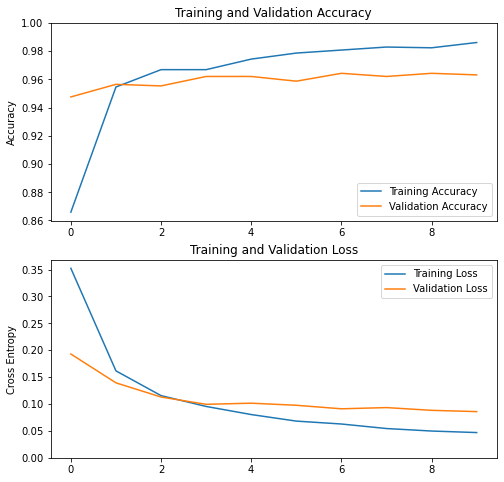

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### 保存模型

In [19]:
model.save("base_mode.h5")

### 在测试图像上应用模型

In [20]:
class_names = {1:'狗', 0:'猫'}  

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [22]:
test_f = load_img("test/dog.jpg", target_size=(image_size, image_size))
test_f = img_to_array(test_f)
test_f = np.expand_dims(test_f,axis=0)
test_f = test_f / 225.

In [23]:
pred = model.predict(test_f)
print(pred)

[[0.93712854]]


In [24]:
result = class_names[0] if pred[0]<0.5 else class_names[1] 
print("预测结果是： %s" %result)

预测结果是： 狗


### 练习题

1. 尝试使用其它预训练模型进行模型训练，如VGG16，ResNet50

参考如下结果：

![](./img/transfer_learning_scores.png)


2. 使用自己的数据集进行迁移学习，看一下迁移效果 